In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_recall_fscore_support, confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
import seaborn as sns


# 1. Load Dataset

In [2]:
data = pd.read_csv("dataset_komentar_instagram_cyberbullying.csv")
data.head()

,Id,Sentiment,Instagram Comment Text
0,1,negative,<USERNAME> TOLOL!! Gak ada hubungan nya kegug...
1,2,negative,Geblek lo tata...cowo bgt dibela2in balikan......
2,3,negative,Kmrn termewek2 skr lengket lg duhhh kok labil ...
3,4,negative,"Intinya kalau kesel dengan ATT nya, gausah ke ..."
4,5,negative,"hadewwwww permpuan itu lg!!!!sakit jiwa,knp ha..."


# 2. Data Cleaning

In [3]:
def clean_text(text):
    text = re.sub(r"<USERNAME>", "", text)  # Remove placeholder username
    text = re.sub(r"http\S+|www\S+", "", text)  # Remove URLs
    text = re.sub(r"\d+", "", text)  # Remove numbers
    text = re.sub(r"[^\x00-\x7F]+", "", text) #remove emoji or non ascii
    text = re.sub(r"[^a-zA-Z ]", "", text)
    text = text.lower().strip()  # Convert to lowercase and strip whitespace
    return text

data['cleaned_text'] = data['Instagram Comment Text'].apply(clean_text)

# 3. Exploratory Data Analysis (EDA)

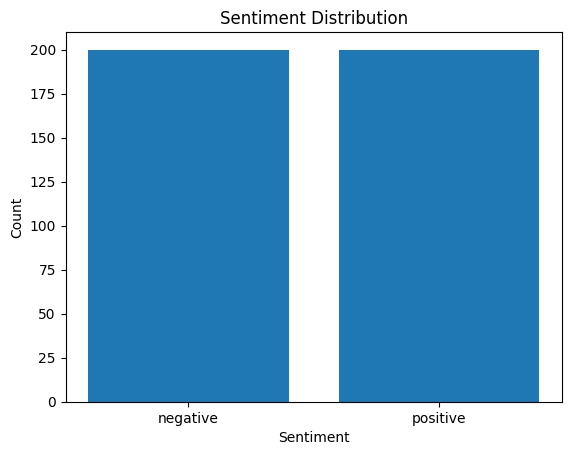

In [4]:
label_counts = data['Sentiment'].value_counts()
plt.bar(label_counts.index, label_counts.values)
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

# 4. Prepare Data for Training

In [5]:
X = data['cleaned_text']
y = data['Sentiment']

# Encode labels (e.g., negative -> 0, positive -> 1)

In [6]:
label_mapping = {label: idx for idx, label in enumerate(y.unique())}
y = y.map(label_mapping)

# Train-test split


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Tokenize text

In [8]:
max_vocab_size = 10000
max_sequence_length = 100
tokenizer = Tokenizer(num_words=max_vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences


In [9]:
X_train_padded = pad_sequences(X_train_seq, maxlen=max_sequence_length, padding="post")
X_test_padded = pad_sequences(X_test_seq, maxlen=max_sequence_length, padding="post")

# 5. Build LSTM Model

In [10]:
embedding_dim = 64
model = Sequential([
    Embedding(input_dim=max_vocab_size, output_dim=embedding_dim, input_length=max_sequence_length),
    LSTM(128, return_sequences=True),
    Dropout(0.2),
    LSTM(64),
    Dropout(0.2),
    Dense(32, activation="relu"),
    Dense(len(label_mapping), activation="softmax")
])

model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()


C:\Users\terate\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

# 6. Train Model


In [13]:
epochs = 5
batch_size = 32
history = model.fit(
    X_train_padded,
    y_train,
    validation_split=0.2,
    epochs=epochs,
    batch_size=batch_size,
    verbose=1
)

Epoch 1/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.4846 - loss: 0.6939 - val_accuracy: 0.4844 - val_loss: 0.6945
Epoch 2/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.5092 - loss: 0.6930 - val_accuracy: 0.4844 - val_loss: 0.6936
Epoch 3/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.4282 - loss: 0.6950 - val_accuracy: 0.4844 - val_loss: 0.6932
Epoch 4/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.5222 - loss: 0.6926 - val_accuracy: 0.5156 - val_loss: 0.6930
Epoch 5/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.5559 - loss: 0.6919 - val_accuracy: 0.4844 - val_loss: 0.6940


In [14]:
# 7. Evaluate Model
loss, accuracy = model.evaluate(X_test_padded, y_test, verbose=1)
print(f"Test Accuracy: {accuracy:.2f}")

precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred_labels, average='weighted')
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5078 - loss: 0.6930
Test Accuracy: 0.50


NameError: name 'y_pred_labels' is not defined

# Generate classification report

In [ ]:
y_pred = model.predict(X_test_padded)
y_pred_labels = np.argmax(y_pred, axis=1)
print("Classification Report:")
print(classification_report(y_test, y_pred_labels, target_names=label_mapping.keys()))

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Classification Report:


C:\Users\terate\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


TypeError: object of type 'numpy.int64' has no len()

# Confusion Matrix

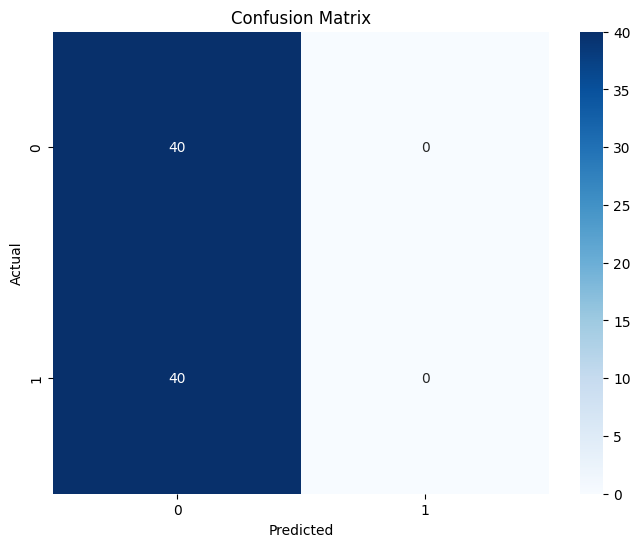

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
